In [2]:
import numpy as np
import json
from .utility import read_csv

ModuleNotFoundError: No module named '__main__.utility'; '__main__' is not a package

In [2]:
data = json.load(open('winemag-data-130k-v2.json'))
print(data[0])


{'points': '87', 'title': 'Nicosia 2013 Vulkà Bianco  (Etna)', 'description': "Aromas include tropical fruit, broom, brimstone and dried herb. The palate isn't overly expressive, offering unripened apple, citrus and dried sage alongside brisk acidity.", 'taster_name': 'Kerin O’Keefe', 'taster_twitter_handle': '@kerinokeefe', 'price': None, 'designation': 'Vulkà Bianco', 'variety': 'White Blend', 'region_1': 'Etna', 'region_2': None, 'province': 'Sicily & Sardinia', 'country': 'Italy', 'winery': 'Nicosia'}


In [3]:
documents = [(x['title'], x['variety'], x['description']) for x in data]

In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
vectorizer = TfidfVectorizer(stop_words = 'english', max_df = .7,
                            min_df = 75)
my_matrix = vectorizer.fit_transform([x[2] for x in documents]).transpose()

In [6]:
print(my_matrix.shape)

(3111, 129971)


In [7]:
from scipy.sparse.linalg import svds
u, s, v_trans = svds(my_matrix, k=100)

In [8]:
print(u.shape)
print(s.shape)
print(v_trans.shape)

(3111, 100)
(100,)
(100, 129971)


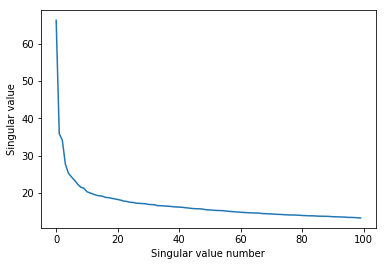

In [9]:
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.plot(s[::-1])
plt.xlabel("Singular value number")
plt.ylabel("Singular value")
plt.show()

In [10]:
words_compressed, _, docs_compressed = svds(my_matrix, k=40)
docs_compressed = docs_compressed.transpose()

In [11]:
print(words_compressed.shape)
print(docs_compressed.shape)


(3111, 40)
(129971, 40)


In [16]:
word_to_index = vectorizer.vocabulary_
index_to_word = {i:t for t,i in word_to_index.items()}
print(words_compressed.shape)


(3111, 40)


In [17]:
from sklearn.preprocessing import normalize
words_compressed = normalize(words_compressed, axis = 1)

In [18]:
def closest_words(word_in, k = 10):
    if word_in not in word_to_index: return "Not in vocab."
    sims = words_compressed.dot(words_compressed[word_to_index[word_in],:])
    asort = np.argsort(-sims)[:k+1]
    return [(index_to_word[i],sims[i]/sims[asort[0]]) for i in asort[1:]]


In [43]:
closest_words("grippy")

[('grip', 0.78755348557490423),
 ('meets', 0.77754062339671215),
 ('shavings', 0.72484568085031009),
 ('meet', 0.71441617473580021),
 ('longtime', 0.7076692776119935),
 ('sip', 0.69426157742835415),
 ('rocky', 0.68046520124818821),
 ('sanguine', 0.67306789128141387),
 ('tension', 0.67155119668674046),
 ('steve', 0.65977892343731448)]

In [25]:
from sklearn.manifold import TSNE
tsne = TSNE(verbose=1)

In [26]:
print(docs_compressed.shape)
#we'll just take the first 5K documents, because TSNE is memory intensive!
subset = docs_compressed[:5000,:]
projected_docs = tsne.fit_transform(subset)
print(projected_docs.shape)

(129971, 40)
[t-SNE] Computing pairwise distances...
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 1000 / 5000
[t-SNE] Computed conditional probabilities for sample 2000 / 5000
[t-SNE] Computed conditional probabilities for sample 3000 / 5000
[t-SNE] Computed conditional probabilities for sample 4000 / 5000
[t-SNE] Computed conditional probabilities for sample 5000 / 5000
[t-SNE] Mean sigma: 0.005034
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.448170
[t-SNE] Error after 350 iterations: 1.448170
(5000, 2)


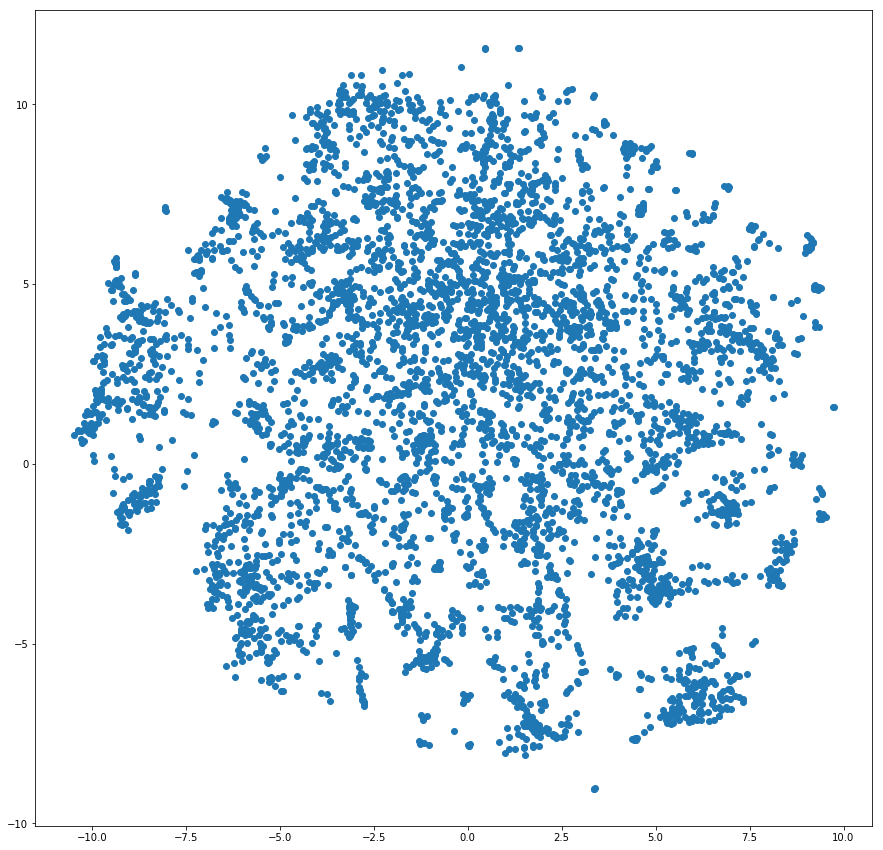

In [27]:
plt.figure(figsize=(15,15))
plt.scatter(projected_docs[:,0],projected_docs[:,1])
plt.show()


In [28]:
from collections import Counter
cats = Counter([x[1] for x in documents])
print(cats)

Counter({'Pinot Noir': 13272, 'Chardonnay': 11753, 'Cabernet Sauvignon': 9472, 'Red Blend': 8946, 'Bordeaux-style Red Blend': 6915, 'Riesling': 5189, 'Sauvignon Blanc': 4967, 'Syrah': 4142, 'Rosé': 3564, 'Merlot': 3102, 'Nebbiolo': 2804, 'Zinfandel': 2714, 'Sangiovese': 2707, 'Malbec': 2652, 'Portuguese Red': 2466, 'White Blend': 2360, 'Sparkling Blend': 2153, 'Tempranillo': 1810, 'Rhône-style Red Blend': 1471, 'Pinot Gris': 1455, 'Champagne Blend': 1396, 'Cabernet Franc': 1353, 'Grüner Veltliner': 1345, 'Portuguese White': 1159, 'Bordeaux-style White Blend': 1066, 'Pinot Grigio': 1052, 'Gamay': 1025, 'Gewürztraminer': 1012, 'Viognier': 996, 'Shiraz': 836, 'Petite Sirah': 770, 'Sangiovese Grosso': 751, 'Barbera': 721, 'Glera': 709, 'Port': 668, 'Grenache': 651, 'Corvina, Rondinella, Molinara': 619, 'Chenin Blanc': 591, 'Tempranillo Blend': 588, 'Carmenère': 575, 'Albariño': 477, 'Pinot Blanc': 442, 'Rhône-style White Blend': 425, "Nero d'Avola": 365, 'Aglianico': 359, 'Moscato': 358, '

In [35]:
from collections import defaultdict
cat_to_color = defaultdict(lambda: 'k')
cat_to_color.update({"Pinot Noir":'g',
               "Chardonnay":'c',
               "Cabernet Sauvignon":'r',
               "Red Blend": "b",
               "Bordeaux-style Red Blend":"y",
               "Riesling":"c",
               "Sauvignon Blanc":"m",
               "Syrah":"y",
               "Rosé":"k",
               "Merlot":"w"})
color_to_project = defaultdict(list)
for i in range(projected_docs.shape[0]):
    color_to_project[cat_to_color[documents[i][1]]].append(i)

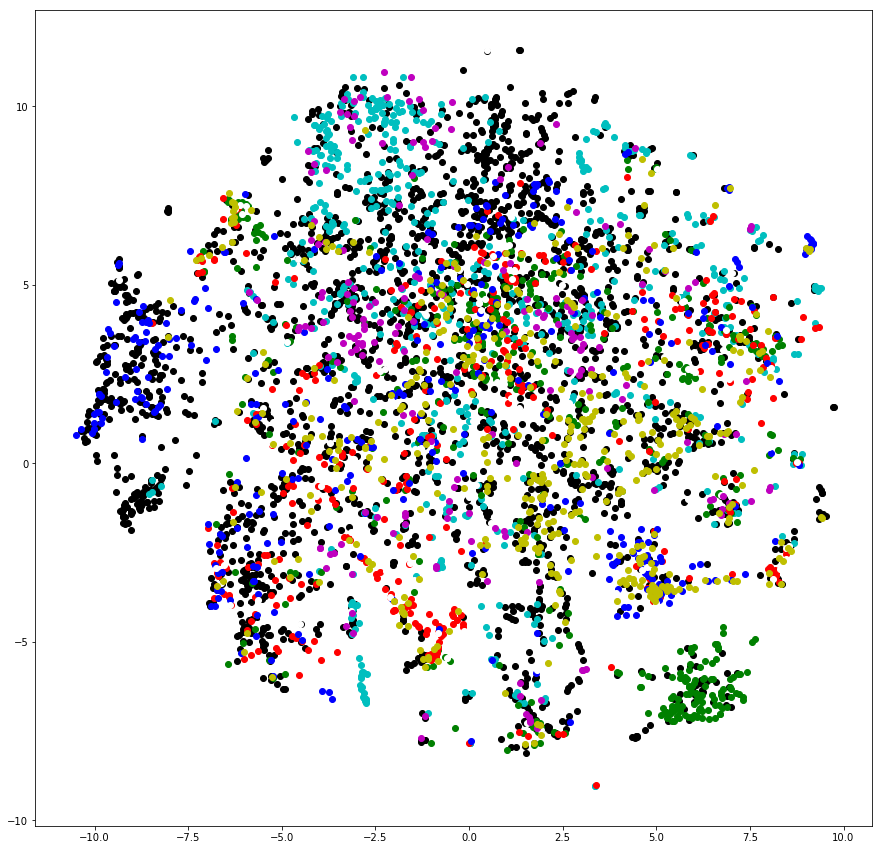

In [34]:
plt.figure(figsize=(15,15))
for color, indices in color_to_project.items():
    indices = np.array(indices)
    plt.scatter(projected_docs[indices,0], projected_docs[indices,1],
                color = color)
plt.show()


In [36]:
docs_compressed = normalize(docs_compressed, axis = 1)
def closest_wine(project_index_in, k = 5):
    sims = docs_compressed.dot(docs_compressed[project_index_in,:])
    asort = np.argsort(-sims)[:k+1]
    return [(documents[i][0],sims[i]/sims[asort[0]]) for i in asort[1:]]

In [38]:
for i in range(10):
    print(documents[i][0])
    for title, score in closest_wine(i):
        print("{}:{:.3f}".format(title[:40], score))
    print()


Nicosia 2013 Vulkà Bianco  (Etna)
Giuseppe Gabbas 2014 Manzanile  (Verment:0.841
Principe di Corleone 2015 Bianca di Cort:0.820
Benanti 2009 Pietramarina Bianco Superio:0.819
Contini 2015 Elibaria  (Vermentino di Ga:0.815
Cantina di Gambellara 2015 Monopolio  (S:0.780

Quinta dos Avidagos 2011 Avidagos Red (Douro)
Quevedo 2014 Claudia's Red (Douro):0.834
Château Fondarzac 2012  Bordeaux Supérie:0.789
Campolargo 2011 Valdazar Red (Bairrada):0.783
Casa Santos Lima 2010 Palha Canas Red (L:0.776
Manuel Olivier 2011  Aloxe-Corton:0.754

Rainstorm 2013 Pinot Gris (Willamette Valley)
Envolve 2012 Sauvignon Blanc (Sonoma Val:0.900
Mount Baker Vineyards 2008 Viognier (Yak:0.828
Michel Torino 2014 Cuma Made With Organi:0.800
Quivira 2012 Fig Tree Vineyard Sauvignon:0.798
Anapamu 2001 Chardonnay (Monterey County:0.794

St. Julian 2013 Reserve Late Harvest Riesling (Lake Michigan Shore)
New Kent 2015 Chardonnay (Virginia):0.880
Leonard Kreusch 2015 Piesporter Michelsb:0.797
Chandon 2007 Vintage Br